# BÁO CÁO BÀI TẬP THỰC HÀNH VÀ ĐỒ ÁN CUỐI KỲ



In [1]:
# import các thư viện
import os
import numpy as np
import pandas as pd
from zipfile import ZipFile
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import display
from tqdm import tqdm

In [2]:
# Các biến toàn cục

# thư mục gốc chứa thư mục dữ liệu
szWorkingDir = "/kaggle/input/car-cs114"

# dùng để hiển thị
nNumImgsPerRow = 10
nImgHeight = nImgWidth = 150

In [3]:
# mapping
labels = {
    'Others': 0,
    'Honda': 1,
    'Hyundai': 2,
    'KIA': 3,
    'Mazda': 4,
    'Mitsubishi': 5,
    'Suzuki': 6,
    'Toyota': 7,
    'VinFast': 8
}
reverse_map_labels = {
    0: 'Others',
    1: 'Honda',
    2: 'Hyundai',
    3: 'KIA',
    4: 'Mazda',
    5: 'Mitsubishi',
    6: 'Suzuki',
    7: 'Toyota',
    8: 'VinFast'
}

Đoạn mã bao gồm:

* File csv chứa ảnh lỗi: Không thể đọc được
* File csv chứa thông tin kênh màu, độ trong suốt
* File csv chứa thông tin các ảnh trùng được phát hiện thông qua bài tập Clustering (trong phần này là tập Train-1)
* Và đường dẫn dataset và train-1.csv

In [4]:
path_img = os.path.join(szWorkingDir, "dataset")
error = pd.read_csv(os.path.join(szWorkingDir,"ImageErrors.csv"))
error_paths = error.iloc[:, 0].unique().tolist() # Lấy thông tin đường dẫn ảnh lỗi

In [5]:
csv_dir = os.path.join(szWorkingDir,"car_split/car_split")
#Link train
img_path_train =os.path.join(csv_dir,"CarDataset-Splits-4-Train.csv")
#Đọc File train
data = pd.read_csv(img_path_train)

In [6]:
data

ImageFullPath  CategoryID
0                Others/22520394-22520395.Others.547.jpg           0
1                Others/22520394-22520395.Others.181.jpg           0
2                Others/22520394-22520395.Others.578.jpg           0
3                Others/22521070-22520211.Others.166.jpg           0
4                Others/22520779-22521587.Others.527.jpg           0
...                                                  ...         ...
29385           VinFast/21522373-21522499.VinFast.10.png           8
29386            VinFast/22521692-22521676.VinFast.7.jpg           8
29387  VinFast/22521259-22521213-22521463.VinFast.13.jpg           8
29388  VinFast/22521027-22520195-22521060.VinFast.092...           8
29389          VinFast/22521070-22520211.VinFast.177.jpg           8

[29390 rows x 2 columns]

Loại bỏ các ảnh lỗi trong tập train

In [7]:
# Loại bỏ các ảnh có trong error_paths
data = data[~data['ImageFullPath'].isin(error_paths)]
data

ImageFullPath  CategoryID
0                Others/22520394-22520395.Others.547.jpg           0
1                Others/22520394-22520395.Others.181.jpg           0
2                Others/22520394-22520395.Others.578.jpg           0
3                Others/22521070-22520211.Others.166.jpg           0
4                Others/22520779-22521587.Others.527.jpg           0
...                                                  ...         ...
29385           VinFast/21522373-21522499.VinFast.10.png           8
29386            VinFast/22521692-22521676.VinFast.7.jpg           8
29387  VinFast/22521259-22521213-22521463.VinFast.13.jpg           8
29388  VinFast/22521027-22520195-22521060.VinFast.092...           8
29389          VinFast/22521070-22520211.VinFast.177.jpg           8

[29372 rows x 2 columns]

In [8]:
# Đọc file chứa thông tin ảnh trùng
duplicates_df = pd.read_csv('/kaggle/input/car-cs114/CheckDuplicate/CheckDuplicate_Train_4.csv')
duplicates_df

ImageFullPath  ClusterID
0                Others/22521492-22521599.Others.49.jpg          0
1                Others/22521492-22521599.Others.50.jpg          0
2                 Others/22521425-22520318.Others.5.jpg          1
3       Others/22521463-22521213-22521259.Others.26.jpg          1
4               Others/22521492-22521599.Others.107.jpg          2
...                                                 ...        ...
1420  VinFast/22521027-22520195-22521060.VinFast.074...        149
1421   VinFast/22521259-22521213-22521463.VinFast.5.jpg        150
1422          VinFast/22521070-22520211.VinFast.193.jpg        150
1423           VinFast/22520477-22520490.VinFast.20.jpg        151
1424  VinFast/22521027-22520195-22521060.VinFast.025...        151

[1425 rows x 2 columns]

Nhóm các ảnh có cùng ClusterID trong file ảnh trùng

Giữ lại ngẫu nhiên một trong số ảnh trùng đó, xoá các ảnh còn lại trong tập train


In [9]:
duplicate_groups = duplicates_df.groupby('ClusterID')['ImageFullPath'].agg(list)

for group in duplicate_groups:
    if len(group) > 1:
        keep_image = np.random.choice(group, 1)[0]
        remove_images = [img for img in group if img != keep_image]
        data = data[~data['ImageFullPath'].isin(remove_images)]

data

ImageFullPath  CategoryID
0                Others/22520394-22520395.Others.547.jpg           0
1                Others/22520394-22520395.Others.181.jpg           0
2                Others/22520394-22520395.Others.578.jpg           0
3                Others/22521070-22520211.Others.166.jpg           0
4                Others/22520779-22521587.Others.527.jpg           0
...                                                  ...         ...
29383  VinFast/22521027-22520195-22521060.VinFast.090...           8
29384           VinFast/22521560-22521614.VinFast.23.jpg           8
29385           VinFast/21522373-21522499.VinFast.10.png           8
29388  VinFast/22521027-22520195-22521060.VinFast.092...           8
29389          VinFast/22521070-22520211.VinFast.177.jpg           8

[28099 rows x 2 columns]

Train and val data

In [10]:
img = data['ImageFullPath']
label = data['CategoryID']
image = [os.path.join(path_img, i) for i in img]
len(image)

28099

#### Chia tập train và val (Train 80%, Val 20%)

In [11]:
train_X, val_X, train_Y, val_Y = train_test_split(image, label, test_size=0.2, random_state=30)
train_label_count = Counter(train_Y)
val_label_count = Counter(val_Y)
print(train_label_count)
print(val_label_count)

Counter({6: 4239, 7: 3720, 0: 2694, 3: 2118, 2: 2105, 4: 2077, 1: 2014, 5: 1845, 8: 1667})
Counter({6: 1031, 7: 869, 0: 687, 1: 548, 2: 541, 3: 530, 4: 510, 5: 477, 8: 427})


### Vizualize tập train và val

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


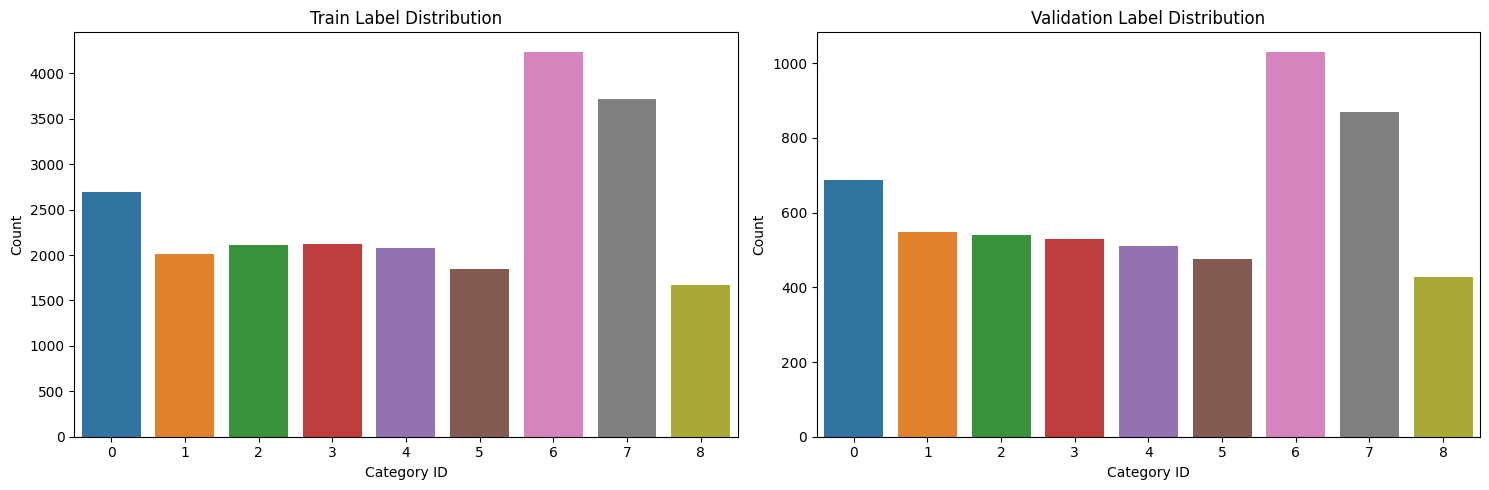

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Giả sử 'train_Y' và 'val_Y' là nhãn của dữ liệu huấn luyện và kiểm tra
train_label_count = Counter(train_Y)
val_label_count = Counter(val_Y)

# Vẽ biểu đồ phân phối nhãn cho cả train và val
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Train label distribution
sns.barplot(x=list(train_label_count.keys()), y=list(train_label_count.values()), ax=axes[0])
axes[0].set_title('Train Label Distribution')
axes[0].set_xlabel('Category ID')
axes[0].set_ylabel('Count')

# Validation label distribution
sns.barplot(x=list(val_label_count.keys()), y=list(val_label_count.values()), ax=axes[1])
axes[1].set_title('Validation Label Distribution')
axes[1].set_xlabel('Category ID')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

Dùng để hiển thị

* nNumImgsPerRow = 10
* nImgHeight = nImgWidth = 150


Duyệt qua từng lớp:

* Lấy ngẫu nhiên 10 ảnh
* Thay đổi kích thước

Tính toán kích thước tổng thể
Hiển thị ảnh

In [13]:
# Số lượng các danh mục hoặc lớp ảnh khác nhau
classes = 9

# Kích thước của mỗi ảnh trong hình
figsize_per_image = (2, 2)

def display_images(data):

    images = {}

    # Lặp qua từng lớp
    for Class in range(classes):
        # Lọc dataframe theo lớp hiện tại
        class_df = data[data['CategoryID'] == Class]

        # Lấy ngẫu nhiên các đường dẫn ảnh từ dataframe đã lọc
        sample_images = class_df.sample(n=min(nNumImgsPerRow, len(class_df)))['ImageFullPath']

        # Tải và thay đổi kích thước từng ảnh được chọn, lưu vào dictionary `images`
        images[Class] = [cv2.resize(cv2.imread(os.path.join(path_img, img_path), cv2.IMREAD_COLOR), (nImgWidth, nImgHeight)) for img_path in sample_images]

    # Tính toán kích thước hình dựa trên số lượng ảnh và số lớp
    figsize = (figsize_per_image[0] * (nNumImgsPerRow + 1), figsize_per_image[1] * classes)

    # Tạo các ô con (subplot) với số dòng là số lớp và số cột là `NumImgsPerRow + 1`
    fig, axes = plt.subplots(classes, nNumImgsPerRow + 1, figsize=figsize)

    # Hiển thị ảnh
    for i in tqdm(range(classes)):
        for j in range(nNumImgsPerRow + 1):
            # Lấy ô subplot hiện tại
            ax = axes[i, j]

            # Nếu là cột đầu tiên, hiển thị nhãn lớp
            if j == 0:
                ax.text(0.5, 0.5, f'{reverse_map_labels[i]}', va='center', ha='center', transform=ax.transAxes, fontsize=14, fontweight='bold')
            # Nếu không, hiển thị ảnh nếu tồn tại
            elif j-1 < len(images[i]):
                ax.imshow(cv2.cvtColor(images[i][j-1], cv2.COLOR_BGR2RGB))

            # Ẩn các đường viền trục để giao diện gọn gàng hơn
            ax.axis('off')

    # Điều chỉnh bố cục để tránh chồng lấn và hiển thị hình
    plt.tight_layout()
    plt.show()

100%|██████████| 9/9 [00:00<00:00, 102.48it/s]


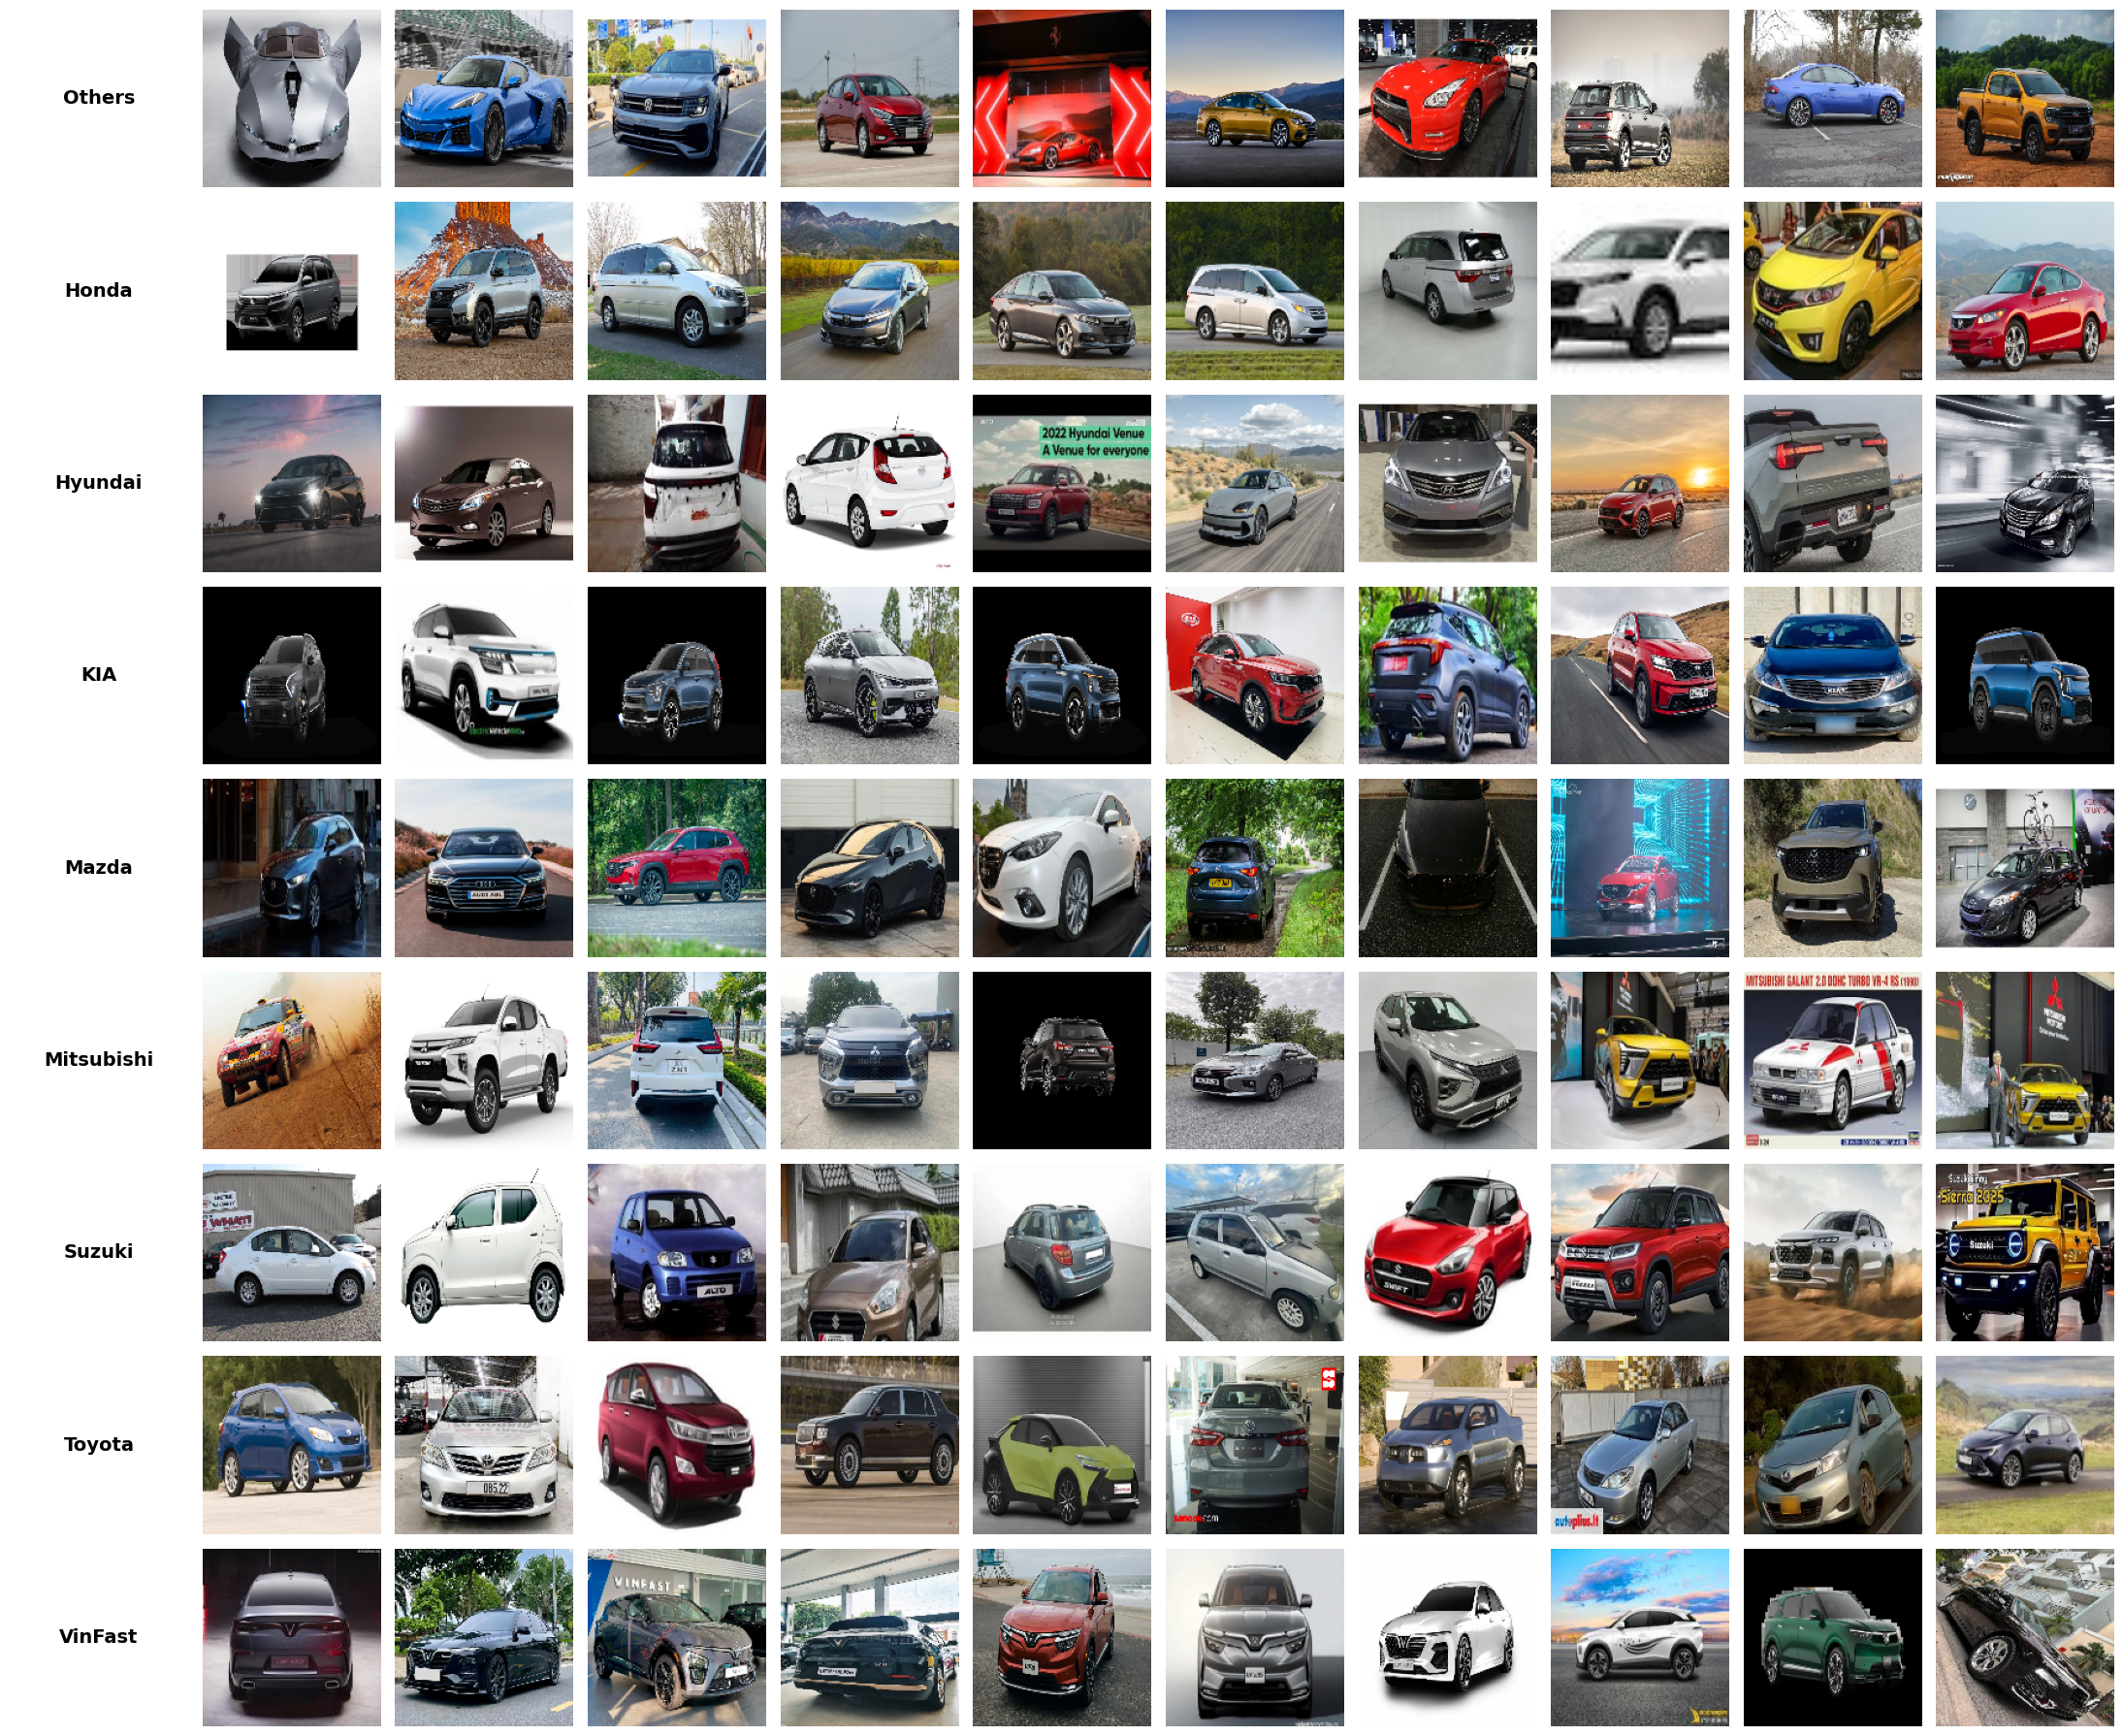

In [14]:
display_images(data)


* Chuyển đổi ảnh sang rgb
* Thay đổi kích thước ảnh thành 224x224 pixels, sử dụng phương pháp nội suy BILINEAR để giữ chất lượng ảnh
* Cắt ảnh ở phần trung tâm để đạt kích thước 224x224 pixels
* Giúp tăng cường dữ liệu ở tập train bằng cách lật ngang ảnh một cách ngẫu nhiên
* Chuyển ảnh từ định dạng PIL Image sang PyTorch tensor, chuyển giá trị pixel từ [0, 255] sang [0.0, 1.0]
* Chuẩn hóa ảnh bằng cách trừ mean và chia cho std (sử dụng các giá trị mean và std của tập ImageNet)


In [15]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),  # Chuyển đổi sang RGB
        transforms.Resize(384, interpolation=Image.BICUBIC),  # Thay đổi kích thước ảnh thành 224x224
        transforms.CenterCrop(384),  # Cắt ảnh từ giữa để có kích thước 224x224
        transforms.RandomHorizontalFlip(),  # Lật ngang ảnh ngẫu nhiên để tăng cường dữ liệu
        transforms.ToTensor(),  # Chuyển ảnh từ định dạng PIL sang tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Chuẩn hóa ảnh dựa trên thông số của ImageNet
    ]),
    'val': transforms.Compose([
        transforms.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),  # Thêm bước chuyển đổi sang RGB
        transforms.Resize(384, interpolation=Image.BICUBIC),  # Thay đổi kích thước ảnh thành 224x224
        transforms.CenterCrop(384),  # Cắt ảnh từ giữa để có kích thước 224x224
        transforms.ToTensor(),  # Chuyển ảnh từ định dạng PIL sang tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Chuẩn hóa ảnh dựa trên thông số của ImageNet
    ]),
}

Kế thừa từ torch.utils.data.Dataset, thường được sử dụng trong PyTorch để tạo tập dữ liệu tuỳ chỉnh

In [16]:
class CustomDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = np.array(labels)
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]

        # Mở ảnh bằng Pillow
        img_pil = Image.open(img_path)

        if img_pil.mode != 'RGB':
            img_pil = img_pil.convert('RGB')

        if self.transform:
            img_pil = self.transform(img_pil)

        return img_pil, label

In [17]:
train_set = CustomDataset(train_X, train_Y, transform=data_transforms['train'])
val_set = CustomDataset(val_X,val_Y, transform=data_transforms['val'])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, pin_memory=True,num_workers=4)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True, pin_memory=True,num_workers= 4)

In [18]:
train_set[0]

(tensor([[[ 2.1804,  2.1804,  2.1804,  ...,  2.1462,  2.1462,  2.1462],
          [ 2.1804,  2.1804,  2.1804,  ...,  2.1462,  2.1462,  2.1462],
          [ 2.1804,  2.1804,  2.1804,  ...,  2.1462,  2.1462,  2.1290],
          ...,
          [ 0.4851,  0.3994,  0.1939,  ...,  0.3138,  0.3652,  0.3309],
          [ 0.2282,  0.0912,  0.2796,  ...,  0.0912,  0.6734,  0.3138],
          [ 0.0056, -0.1828,  0.2624,  ...,  0.1426,  0.4679,  0.6392]],
 
         [[ 2.3585,  2.3585,  2.3585,  ...,  2.3235,  2.3235,  2.3235],
          [ 2.3585,  2.3585,  2.3585,  ...,  2.3235,  2.3235,  2.3235],
          [ 2.3585,  2.3585,  2.3585,  ...,  2.3235,  2.3235,  2.3060],
          ...,
          [ 0.4853,  0.3627,  0.1527,  ...,  0.2402,  0.2752,  0.2402],
          [ 0.2052,  0.0476,  0.2402,  ...,  0.0126,  0.6429,  0.2927],
          [-0.0224, -0.2325,  0.2227,  ...,  0.0826,  0.5378,  0.7129]],
 
         [[ 2.5703,  2.5703,  2.5703,  ...,  2.5354,  2.5354,  2.5354],
          [ 2.5703,  2.5703,

In [19]:
val_set[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

Show 16 ảnh trong 1 batch

In [20]:
def show_batch_images(images, labels, mean, std, max_images=16):
    # Ensure mean and std are numpy arrays
    mean = np.array(mean)
    std = np.array(std)

    plt.figure(figsize=(12, 12))
    for i in range(min(len(images), max_images)):
        image = images[i].numpy().transpose((1, 2, 0))  # Transpose tensor from (C, H, W) to (H, W, C)

        # Denormalize
        image = std * image + mean
        image = np.clip(image, 0, 1)  # Ensure values are in [0, 1]

        plt.subplot(4, 4, i + 1)  # 4 rows and 4 columns
        plt.imshow(image)
        plt.title(f'Label: {labels[i].item()}')
        plt.axis('off')
    plt.show()

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


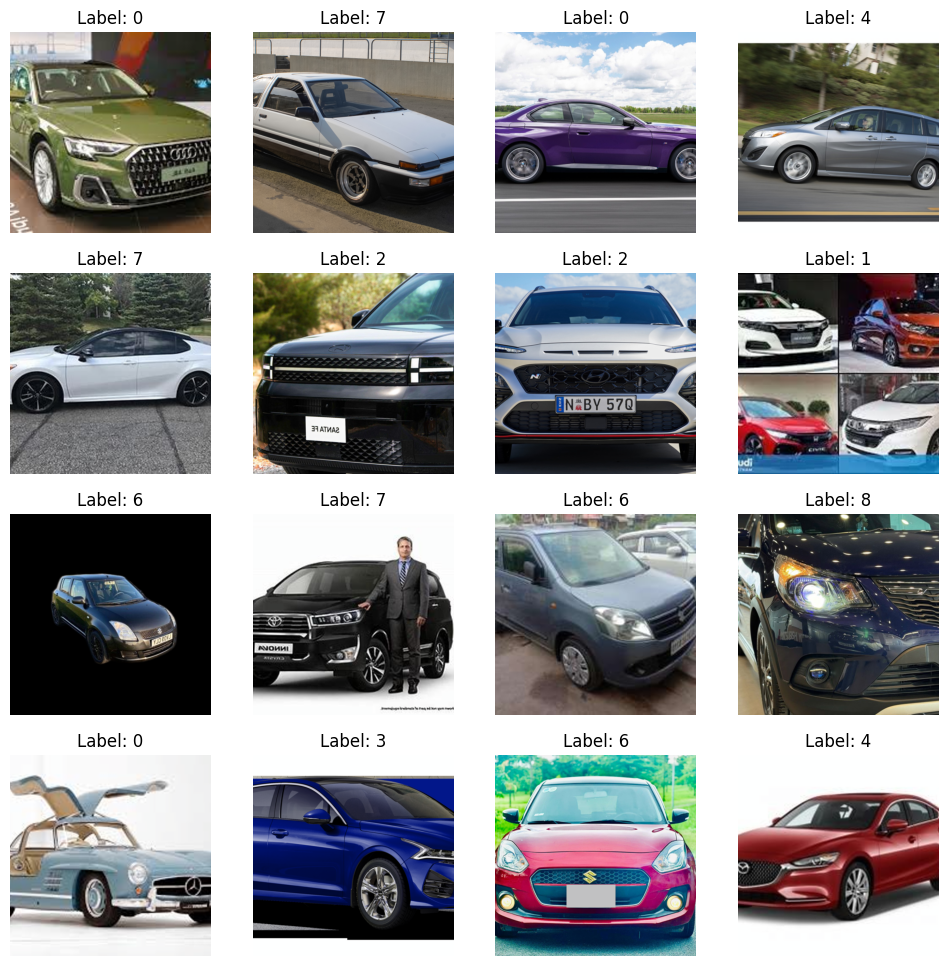

In [21]:
batch_images, batch_labels = next(iter(train_loader))  # Replace data_loader with your actual DataLoader
show_batch_images(batch_images, batch_labels, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [22]:
from tempfile import TemporaryDirectory
import torch.optim as optim
import time
import torchvision.models as models
from torch.optim import lr_scheduler

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [24]:
import torch
# Kiểm tra GPU memory trước khi load model
print(f"GPU memory before model: {torch.cuda.memory_allocated()/1e9:.2f} GB")
torch.cuda.empty_cache()

GPU memory before model: 0.00 GB


* Sử dụng mô hình RegNet_Y_128GF đã được huấn luyện trước trên tập dữ liệu ImageNet.
* Đóng băng toàn bộ các lớp trong mô hình để các tham số không bị cập nhật trong quá trình huấn luyện. Chỉ mở khóa lớp block4 (block cuối cùng trong trunk_output) để các tham số trong lớp này có thể được cập nhật trong quá trình huấn luyện.
* Lớp fully connected ban đầu (dùng để phân loại 1000 lớp trong ImageNet) được thay thế bằng một cấu trúc mới gồm:
    * Một lớp ẩn với 1024 node, kích hoạt bằng ReLU và dropout.
    * Một lớp ẩn tiếp theo với 512 node, cũng kích hoạt bằng ReLU và dropout.
    * Lớp cuối cùng với 9 node tương ứng với số lớp trong bài toán.


In [25]:
from torchvision.models import regnet_y_128gf, RegNet_Y_128GF_Weights

weights = RegNet_Y_128GF_Weights.IMAGENET1K_SWAG_E2E_V1  # Dùng E2E đúng yêu cầu
model_ft = regnet_y_128gf(weights=weights)

# Unfreeze the last few layers
for param in model_ft.parameters():
    param.requires_grad = False

# Unfreeze the last block and the final fully connected layer
for param in model_ft.trunk_output.block4.parameters():
    param.requires_grad = True

# Replace the last fully connected layer with a new one
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 9)  # Assuming you have 9 classes
)

# Move model to device (GPU if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/regnet_y_128gf_swag-c8ce3e52.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_128gf_swag-c8ce3e52.pth
100%|██████████| 2.40G/2.40G [00:11<00:00, 217MB/s]


In [26]:
model_ft

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(528, 528, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
      

* step_size=5: Giảm tốc độ học sau mỗi 5 epoch.
* gamma=0.1: Hệ số giảm, tức tốc độ học mới = tốc độ học hiện tại × 0.1.

In [27]:
criterion = nn.CrossEntropyLoss()

# Define optimizer (SGD with momentum)
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)


# Define learning rate scheduler (decay LR by a factor of 0.1 every 5 epochs)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)
exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=10)

In [28]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15, train_loader=None, val_loader=None, device=None):
    since = time.time()
    best_acc = 0.0
    best_model_params_path = '/kaggle/working/regnet_e2e_tune_04.pt'
    
    # Histories
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    # Grad scaler for mixed precision
    scaler = torch.amp.GradScaler('cuda')
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 30)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=f'{phase} {epoch+1}/{num_epochs}'):
                try:
                    # Move input and labels to device
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    # Verify shapes and values
                    assert inputs.shape[1:] == (3, 384, 384), f"Wrong input shape: {inputs.shape}"
                    assert labels.shape[0] == inputs.shape[0], f"Batch size mismatch: {labels.shape} vs {inputs.shape}"
                    assert torch.all(labels >= 0) and torch.all(labels < 9), f"Labels out of range: {labels.min()}-{labels.max()}"
                    
                    # Zero the parameter gradients
                    optimizer.zero_grad()
                    
                    # Forward
                    with torch.set_grad_enabled(phase == 'train'):
                        with torch.amp.autocast('cuda'):
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)
                            _, preds = torch.max(outputs, 1)
                        
                        # Backward + optimize only if in training phase
                        if phase == 'train':
                            scaler.scale(loss).backward()
                            scaler.step(optimizer)
                            scaler.update()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                except Exception as e:
                    print(f"Error in batch processing: {str(e)}")
                    print(f"Input shape: {inputs.shape}")
                    print(f"Labels shape: {labels.shape}")
                    print(f"Unique labels: {torch.unique(labels)}")
                    raise e
            
            # Epoch statistics
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)
                
            # Update histories
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
                scheduler.step()
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(torch.load(best_model_params_path))
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

In [29]:
model, train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15, train_loader=train_loader, val_loader=val_loader, device=device
)

Epoch 1/15
------------------------------


train 1/15:   0%|          | 0/703 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 1/15:   1%|          | 5/703 [00:20<42:08,  3.62s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 1/15:   4%|▎         | 26/703 [01:28<36:42,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 1/15:   9%|▊         | 60/703 [03:19<34:52,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 1/15: 100%|██████████| 703/703 [38:09<00:00,  3.26s/it]


train Loss: 1.6459 Acc: 0.4214


val 1/15:  14%|█▍        | 25/176 [01:08<06:45,  2.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 1/15:  40%|████      | 71/176 [03:12<04:41,  2.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 1/15:  45%|████▌     | 80/176 [03:36<04:17,  2.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 1/15:  47%|████▋     | 82/176 [03:41<04:12,  2.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 1/15: 100%|██████████| 176/176 [07:53<00:00,  2.69s/it]


val Loss: 0.8978 Acc: 0.7135

Epoch 2/15
------------------------------


train 2/15:   9%|▉         | 65/703 [03:32<34:35,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 2/15:  13%|█▎        | 92/703 [05:00<33:07,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 2/15:  14%|█▎        | 95/703 [05:10<32:57,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 2/15:  21%|██        | 146/703 [07:56<30:11,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 2/15: 100%|██████████| 703/703 [38:06<00:00,  3.2

train Loss: 0.7921 Acc: 0.7397


val 2/15:   8%|▊         | 14/176 [00:39<07:15,  2.69s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 2/15:  26%|██▌       | 45/176 [02:02<05:51,  2.69s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 2/15:  27%|██▋       | 47/176 [02:07<05:46,  2.69s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 2/15:  57%|█████▋    | 100/176 [04:30<03:24,  2.69s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 2/15: 100%|██████████| 176/176 [07:54<00:00,  2.69s/it]


val Loss: 0.5815 Acc: 0.8114

Epoch 3/15
------------------------------


train 3/15:   1%|▏         | 10/703 [00:34<37:50,  3.28s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 3/15:  15%|█▌        | 107/703 [05:50<32:19,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 3/15:  15%|█▌        | 108/703 [05:53<32:16,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 3/15:  44%|████▍     | 309/703 [16:47<21:22,  3.26s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 3/15: 100%|██████████| 703/703 [38:08<00:00,  3

train Loss: 0.5700 Acc: 0.8142


val 3/15:  29%|██▉       | 51/176 [02:17<05:35,  2.69s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 3/15:  38%|███▊      | 66/176 [02:58<04:55,  2.69s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 3/15:  55%|█████▍    | 96/176 [04:18<03:34,  2.69s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 3/15:  62%|██████▏   | 109/176 [04:53<02:59,  2.69s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 3/15: 100%|██████████| 176/176 [07:53<00:00,  2.69s/it]


val Loss: 0.5001 Acc: 0.8386

Epoch 4/15
------------------------------


train 4/15:   4%|▍         | 29/703 [01:35<36:33,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 4/15:   7%|▋         | 47/703 [02:34<35:35,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 4/15:  10%|▉         | 68/703 [03:42<34:26,  3.26s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 4/15:  11%|█         | 78/703 [04:15<33:54,  3.26s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 4/15: 100%|██████████| 703/703 [38:07<00:00,  3.25

train Loss: 0.4534 Acc: 0.8526


val 4/15:   6%|▌         | 10/176 [00:30<07:32,  2.72s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 4/15:   6%|▋         | 11/176 [00:32<07:27,  2.71s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 4/15:  20%|██        | 36/176 [01:39<06:15,  2.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 4/15:  28%|██▊       | 49/176 [02:14<05:40,  2.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 4/15: 100%|██████████| 176/176 [07:55<00:00,  2.70s/it]


val Loss: 0.4661 Acc: 0.8448

Epoch 5/15
------------------------------


train 5/15:   2%|▏         | 11/703 [00:36<37:37,  3.26s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 5/15:   2%|▏         | 17/703 [00:56<37:12,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 5/15:   4%|▍         | 28/703 [01:32<36:35,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 5/15:   8%|▊         | 54/703 [02:56<35:11,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 5/15: 100%|██████████| 703/703 [38:06<00:00,  3.25

train Loss: 0.3537 Acc: 0.8842


val 5/15:   0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 5/15:  22%|██▏       | 39/176 [01:46<06:07,  2.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 5/15:  35%|███▍      | 61/176 [02:45<05:08,  2.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 5/15:  44%|████▍     | 78/176 [03:30<04:22,  2.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 5/15: 100%|██████████| 176/176 [07:53<00:00,  2.69s/it]


val Loss: 0.4515 Acc: 0.8584

Epoch 6/15
------------------------------


train 6/15:   4%|▍         | 30/703 [01:39<36:28,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 6/15:   4%|▍         | 31/703 [01:42<36:25,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 6/15:  10%|▉         | 68/703 [03:42<34:24,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 6/15:  10%|█         | 73/703 [03:58<34:08,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 6/15: 100%|██████████| 703/703 [38:06<00:00,  3.25

train Loss: 0.2828 Acc: 0.9089


val 6/15:   0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 6/15:   3%|▎         | 5/176 [00:14<07:53,  2.77s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 6/15:  27%|██▋       | 48/176 [02:09<05:43,  2.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 6/15:  44%|████▍     | 78/176 [03:30<04:22,  2.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 6/15: 100%|██████████| 176/176 [07:53<00:00,  2.69s/it]


val Loss: 0.4217 Acc: 0.8681

Epoch 7/15
------------------------------


train 7/15:   0%|          | 2/703 [00:08<48:12,  4.13s/it]  /usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 7/15:   1%|          | 4/703 [00:15<41:13,  3.54s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 7/15:   4%|▍         | 29/703 [01:36<36:32,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 7/15:   8%|▊         | 59/703 [03:14<34:54,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 7/15: 100%|██████████| 703/703 [38:06<00:00,  3.25

train Loss: 0.2246 Acc: 0.9279


val 7/15:   9%|▉         | 16/176 [00:44<07:09,  2.69s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 7/15:  15%|█▍        | 26/176 [01:11<06:42,  2.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 7/15:  21%|██        | 37/176 [01:41<06:12,  2.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 7/15: 100%|██████████| 176/176 [07:53<00:00,  2.69s/it]


val Loss: 0.4249 Acc: 0.8694

Epoch 8/15
------------------------------


train 8/15:   0%|          | 0/703 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 8/15:   2%|▏         | 14/703 [00:48<37:26,  3.26s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 8/15:   7%|▋         | 49/703 [02:42<35:27,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 8/15:  40%|███▉      | 280/703 [15:13<22:55,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 8/15: 100%|██████████| 703/703 [38:07<00:00,  3.25s/it]


train Loss: 0.1908 Acc: 0.9419


val 8/15:   1%|          | 1/176 [00:03<10:54,  3.74s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 8/15:   6%|▋         | 11/176 [00:30<07:24,  2.69s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 8/15:   8%|▊         | 14/176 [00:38<07:15,  2.69s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 8/15:  45%|████▌     | 80/176 [03:35<04:17,  2.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 8/15: 100%|██████████| 176/176 [07:53<00:00,  2.69s/it]


val Loss: 0.4150 Acc: 0.8778

Epoch 9/15
------------------------------


train 9/15:   0%|          | 0/703 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 9/15:   1%|          | 8/703 [00:27<38:07,  3.29s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 9/15:   3%|▎         | 19/703 [01:03<37:05,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 9/15:   4%|▍         | 30/703 [01:39<36:28,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 9/15: 100%|██████████| 703/703 [38:06<00:00,  3.25s/it]


train Loss: 0.1693 Acc: 0.9473


val 9/15:   0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 9/15:   3%|▎         | 6/176 [00:18<07:59,  2.82s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 9/15:  26%|██▌       | 45/176 [02:03<05:51,  2.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 9/15:  84%|████████▍ | 148/176 [06:39<01:15,  2.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 9/15: 100%|██████████| 176/176 [07:54<00:00,  2.70s/it]


val Loss: 0.4181 Acc: 0.8751

Epoch 10/15
------------------------------


train 10/15:   4%|▍         | 30/703 [01:39<36:28,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 10/15:   8%|▊         | 53/703 [02:54<35:13,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 10/15:  11%|█         | 75/703 [04:05<34:02,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 10/15:  33%|███▎      | 232/703 [12:36<25:31,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 10/15: 100%|██████████| 703/703 [38:06<00:00,

train Loss: 0.1553 Acc: 0.9509


val 10/15:   0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 10/15:  36%|███▋      | 64/176 [02:53<05:00,  2.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 10/15:  54%|█████▍    | 95/176 [04:17<03:37,  2.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 10/15: 100%|██████████| 176/176 [07:54<00:00,  2.70s/it]


val Loss: 0.4131 Acc: 0.8772

Epoch 11/15
------------------------------


train 11/15:   0%|          | 0/703 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 11/15:   4%|▍         | 29/703 [01:35<36:31,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 11/15:   4%|▍         | 31/703 [01:42<36:25,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 11/15:  13%|█▎        | 90/703 [04:54<33:13,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 11/15: 100%|██████████| 703/703 [38:06<00:00,  3.25s/it

train Loss: 0.1558 Acc: 0.9513


val 11/15:   0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 11/15:  27%|██▋       | 47/176 [02:07<05:46,  2.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 11/15:  39%|███▊      | 68/176 [03:03<04:49,  2.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 11/15:  51%|█████     | 90/176 [04:02<03:50,  2.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 11/15: 100%|██████████| 176/176 [07:53<00:00,  2.69s/it]


val Loss: 0.4134 Acc: 0.8763

Epoch 12/15
------------------------------


train 12/15:   1%|          | 7/703 [00:23<38:12,  3.29s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 12/15:   1%|▏         | 9/703 [00:30<37:50,  3.27s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 12/15:   6%|▌         | 40/703 [02:11<35:56,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 12/15:  16%|█▌        | 114/703 [06:11<31:55,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 12/15: 100%|██████████| 703/703 [38:05<00:00,  

train Loss: 0.1516 Acc: 0.9534


val 12/15:   4%|▍         | 7/176 [00:20<07:44,  2.75s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 12/15:  14%|█▍        | 25/176 [01:08<06:45,  2.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 12/15:  23%|██▎       | 40/176 [01:49<06:04,  2.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 12/15: 100%|██████████| 176/176 [07:53<00:00,  2.69s/it]


val Loss: 0.4193 Acc: 0.8742

Epoch 13/15
------------------------------


train 13/15:   0%|          | 0/703 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 13/15:   2%|▏         | 13/703 [00:43<37:28,  3.26s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 13/15:  19%|█▊        | 131/703 [07:07<30:59,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 13/15:  32%|███▏      | 226/703 [12:16<25:51,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 13/15: 100%|██████████| 703/703 [38:06<00:00,  3.25s/

train Loss: 0.1585 Acc: 0.9504


val 13/15:  10%|▉         | 17/176 [00:48<07:07,  2.69s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 13/15:  15%|█▌        | 27/176 [01:14<06:39,  2.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 13/15:  26%|██▌       | 46/176 [02:05<05:48,  2.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 13/15:  32%|███▏      | 56/176 [02:32<05:22,  2.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 13/15: 100%|██████████| 176/176 [07:54<00:00,  2.70s/it]

val Loss: 0.4097 Acc: 0.8754

Epoch 14/15
------------------------------


train 14/15:   0%|          | 0/703 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 14/15:   2%|▏         | 11/703 [00:38<37:48,  3.28s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 14/15:   3%|▎         | 22/703 [01:14<36:55,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 14/15:   3%|▎         | 24/703 [01:21<36:48,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 14/15: 100%|██████████| 703/703 [38:07<00:00,  3.25s/it

train Loss: 0.1520 Acc: 0.9508


val 14/15:   6%|▌         | 10/176 [00:28<07:28,  2.70s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 14/15:  21%|██        | 37/176 [01:40<06:12,  2.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 14/15:  29%|██▉       | 51/176 [02:18<05:35,  2.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 14/15:  32%|███▏      | 56/176 [02:31<05:21,  2.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 14/15: 100%|██████████| 176/176 [07:53<00:00,  2.69s/it]

val Loss: 0.4098 Acc: 0.8769

Epoch 15/15
------------------------------


train 15/15:   3%|▎         | 23/703 [01:16<36:51,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 15/15:   4%|▍         | 28/703 [01:32<36:34,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 15/15:  10%|█         | 73/703 [03:59<34:08,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 15/15:  18%|█▊        | 126/703 [06:51<31:16,  3.25s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 15/15: 100%|██████████| 703/703 [38:06<00:00,

train Loss: 0.1458 Acc: 0.9536


val 15/15:   0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 15/15:  72%|███████▏  | 127/176 [05:41<02:11,  2.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 15/15: 100%|██████████| 176/176 [07:53<00:00,  2.69s/it]
<ipython-input-28-4bf461346fcf>:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default 

val Loss: 0.4348 Acc: 0.8738

Training complete in 691m 1s
Best val Acc: 0.8778


In [30]:
def plot_training_history(train_loss_history, val_loss_history, train_acc_history, val_acc_history):
    # Ensure that the histories are converted to NumPy arrays if they are tensors
    if isinstance(train_loss_history, list):
        train_loss_history = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_loss_history]
    if isinstance(val_loss_history, list):
        val_loss_history = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in val_loss_history]
    if isinstance(train_acc_history, list):
        train_acc_history = [acc.detach().cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in train_acc_history]
    if isinstance(val_acc_history, list):
        val_acc_history = [acc.detach().cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in val_acc_history]

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

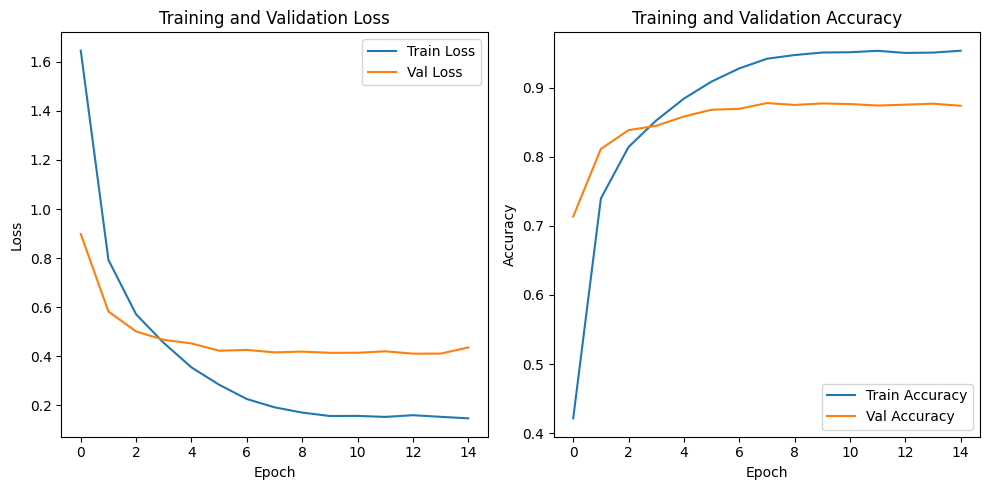

In [31]:
plot_training_history(train_loss_history, val_loss_history, train_acc_history, val_acc_history)